# Práctica sobre algoritmos genéticos

<img src="imgs/tren.jpg">


Un área ferroviaria de carga/descarga con una única vía de entrada y otra salida se compone de tres muelles de carga/descarga: Op1, Op2 y Op3, correspondientes a contenedores, carbón y gas. Por tanto, cada tren que llega se dirige a un muelle en función de su carga. Un tren tarda en cargar o descargar un tiempo proporcional al número de vagones que arrastra. Cada día llegan secuencialmente n trenes. Si los trenes son de cargas distintas, pueden entrar en paralelo a los muelles. Cuando dos trenes con el mismo tipo de carga se encuentran seguidos, el segundo debe esperar por el primero, así como todos los demás que se encuentren por detrás.


Se nos plantea resolver, mediante un algoritmo genético, el problema de la ordenación en la entrada de los trenes para minimizar el tiempo de paso del conjunto de trenes.


<img src="imgs/docks.jpg" width="70%">

In [93]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

## Trenes

En el siguiente código, <code>random_trains_generation</code> genera los trenes que llegarán en un día. Cada ordenación diferente de este conjunto corresponderá con un **individuo** en nuestro eaquema de algoritmo genético.

In [96]:
import random
from deap import base, creator, tools

class Train:
    def __init__(self, wagons, op, id):
        self.wagons = wagons
        self.op = op
        self.id = id

    def __str__(self):
        return "Número de vagones:" + str(self.wagons) + "\n" + "Muelle de operaciones:" + str(self.op)


def random_trains_generation(n):

    train_list = []
    
    for i in range(n):
        wagons = random.randint(10, 30)  # Cada tren puede arrastrar entre 10 y 30 vagones
        op = random.choice(["op1", "op2", "op3"])  # A cada tren se le asigna un tipo de carga
        train_list.append(Train(wagons, op, i))

    print(len(train_list))
    return train_list
    


incoming_trains = random_trains_generation(100)  # supongamos que entran 7 trenes


# Crea una nueva reordenación de los trenes entrantes
def create_queue():
    aux = incoming_trains[:]
    random.shuffle(aux)
    return aux


class Trains(list):
    def __init__(self):
        list.extend(self, create_queue())


def evaluation(individual):
    dock_op_counters = {"op1" : 0, "op2" : 0, "op3" : 0}
    time = 0

    for train in individual:
        next_delay = train.wagons
        if dock_op_counters[train.op] == 0:
            dock_op_counters[train.op] = next_delay
        else:
            current_delay = dock_op_counters[train.op]
            for k, v in dock_op_counters.items():
                dock_op_counters[k] = max(0, v - current_delay)
            dock_op_counters[train.op] = next_delay
            time += current_delay

    time += max(dock_op_counters.values())
    return time,

100


In [97]:
def train_mate(ind1, ind2):
    cut_index = np.random.randint(len(ind1))
    ind1_left, ind1_right = ind1[:cut_index], ind1[cut_index:]
    ind2_left, ind2_right = ind2[:cut_index], ind2[cut_index:]
    
    pool1 = set(ind1) - (set(ind1_left) | set(ind2_right))
    pool2 = set(ind2) - (set(ind2_left) | set(ind1_right))
    
    ind1_right_new = []
    for t in ind2_right:
        if t not in ind1_left:
            ind1_right_new.append(t)
        else:
            ind1_right_new.append(pool1.pop())
    
    ind2_right_new = []
    for t in ind1_right:
        if t not in ind2_left:
            ind2_right_new.append(t)
        else:
            ind2_right_new.append(pool2.pop())
    
    ind1[:] = ind1_left + ind2_right_new
    ind2[:] = ind2_left + ind1_right_new
    
    return ind1, ind2

In [98]:
##################### DEAP #####################

creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", Trains, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("individual", creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluation)
toolbox.register("mate", train_mate)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=50)

In [99]:
hof = tools.HallOfFame(4)

stats = tools.Statistics(lambda indiv: indiv.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=300, stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg    	min 	max 
0  	50    	1112.48	1007	1213
1  	33    	1059.2 	1007	1171
2  	30    	1033.8 	988 	1084
3  	31    	1019.06	988 	1068
4  	35    	1009.6 	959 	1071
5  	32    	996.72 	959 	1075
6  	36    	988.1  	955 	1086
7  	33    	978.88 	945 	1049
8  	29    	970.1  	944 	1018
9  	29    	959.5  	929 	1038
10 	27    	955.36 	915 	1018
11 	23    	942.84 	911 	992 
12 	31    	941.64 	911 	1008
13 	32    	932.8  	911 	1014
14 	32    	926.78 	895 	1053
15 	30    	915.62 	906 	969 
16 	24    	917.32 	906 	984 
17 	27    	914.74 	906 	979 
18 	19    	913.94 	898 	973 
19 	33    	912.22 	859 	1010
20 	25    	908.3  	859 	967 
21 	33    	900.26 	859 	984 
22 	27    	896.46 	859 	951 
23 	37    	893.32 	859 	969 
24 	33    	883.48 	859 	1012
25 	30    	875.5  	857 	995 
26 	40    	871.46 	843 	963 
27 	34    	870.76 	843 	955 
28 	31    	862.96 	843 	931 
29 	31    	867.88 	843 	966 
30 	27    	857.46 	830 	940 
31 	24    	855.04 	830 	955 
32 	26    	846.24 	830 	922 
33 	36    	839

284	22    	761.22 	746 	862 
285	33    	767.98 	746 	871 
286	20    	753.12 	746 	835 
287	30    	752.26 	746 	836 
288	33    	752.1  	746 	864 
289	34    	758.48 	744 	866 
290	30    	754.48 	744 	872 
291	24    	756.36 	744 	872 
292	29    	756.4  	744 	892 
293	25    	752.84 	744 	841 
294	28    	762.56 	744 	868 
295	30    	760.38 	744 	904 
296	31    	754.72 	744 	841 
297	29    	755.02 	744 	887 
298	32    	753.54 	744 	843 
299	27    	759.26 	744 	918 
300	34    	762.02 	744 	850 


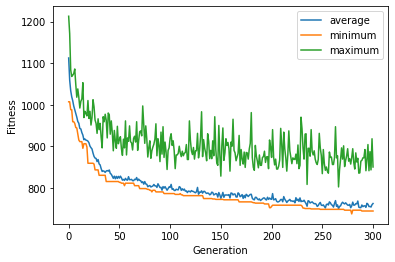

In [100]:
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

Para tener una idea de lo bueno que puede ser un resultado vamos a calcular cuál sería el tiempo mínimo en una supuesta configuración ideal de trenes. Para ello, asumimos que cada tipo de operación no bloquea a las otras. Por tanto, sumamos los tiempos para cada operación de forma independiente. Ahora, entre estos tres valores resultantes, escogemos el máximo. Ese será el tiempo que, como mínimo, tardarían todos los trenes en pasar.

In [101]:
counters = {"op1":0, "op2":0, "op3":0}

for t in incoming_trains:
    counters[t.op] += t.wagons
    
print("Tiempo op1:", counters["op1"], "\nTiempo op2:", counters["op2"], "\nTiempo op3:", counters["op3"])
             
print("Por tanto, el tiempo mínimo será:", max(counters["op1"], counters["op2"], counters["op3"]))
print("Y el tiempo calculado por el AG es de:", hof[0].fitness)

Tiempo op1: 663 
Tiempo op2: 693 
Tiempo op3: 708
Por tanto, el tiempo mínimo será: 708
Y el tiempo calculado por el AG es de: (737.0,)


In [115]:
counter_set = set()
for t in hof[0]:
    counter_set.add(t.id)
    
print(len(counter_set))
print(sorted(list(counter_set)))

100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [61]:
mt = random_trains_generation(100)
print(len(mt))

100
100
